In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

df = pd.read_csv("data/full_data_encoded.csv", low_memory=False)

In [2]:
df

,index,Unnamed: 0,Date,Year,Month,Global Temperature Anomalies,Global Precipitation,Nino 1+2 SST,Nino 1+2 SST Anomalies,Nino 3 SST,...,Season (2-Month),MEI.ext,MEI.v2,Season (3-Month),ONI,Season (12-Month),ENSO Phase-Intensity,high,low,ENSO_encoded
0,120,120,1960-01-01,1960,JAN,0.04,NaN,NaN,NaN,NaN,...,DJ,-0.070,NaN,DJF,-0.1,1960-1961,N,32.290323,17.432258,0
1,121,121,1960-02-01,1960,FEB,0.15,NaN,NaN,NaN,NaN,...,JF,0.073,NaN,JFM,-0.1,1960-1961,N,30.275862,14.055172,0
2,122,122,1960-03-01,1960,MAR,-0.24,NaN,NaN,NaN,NaN,...,FM,0.106,NaN,FMA,-0.1,1960-1961,N,31.645161,12.535484,0
3,123,123,1960-04-01,1960,APR,-0.11,NaN,NaN,NaN,NaN,...,MA,0.167,NaN,MAM,0.0,1960-1961,N,58.566667,37.913333,0
4,124,124,1960-05-01,1960,MAY,-0.07,NaN,NaN,NaN,NaN,...,AM,0.177,NaN,AMJ,0.0,1960-1961,N,65.548387,47.412903,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775,895,895,2024-08-01,2024,AUG,1.27,84.55,20.52,-0.34,24.97,...,JA,NaN,-0.73,JAS,-0.1,2024-2025,N,79.387097,61.129032,0
776,896,896,2024-09-01,2024,SEP,1.25,80.73,19.91,-0.68,24.85,...,AS,NaN,-0.65,ASO,-0.2,2024-2025,N,76.833333,54.933333,0
777,897,897,2024-10-01,2024,OCT,1.33,84.96,20.55,-0.32,25.04,...,SO,NaN,-0.52,SON,-0.3,2024-2025,N,66.129032,42.651613,0
778,898,898,2024-11-01,2024,NOV,1.32,81.76,21.88,0.26,25.17,...,ON,NaN,-0.68,OND,-0.4,2024-2025,N,49.666667,37.733333,0


In [3]:
# Keep only what's needed
df = df[["Year", "Month", "high"]].dropna()

# Month order (ensure correct x-axis order)
month_order = ["JAN","FEB","MAR","APR","MAY","JUN","JUL","AUG","SEP","OCT","NOV","DEC"]
df["Month"] = pd.Categorical(df["Month"], categories=month_order, ordered=True)

# If duplicates exist per Year×Month, average them (retain current pandas behavior)
df = df.groupby(["Year", "Month"], as_index=False, observed=False)["high"].mean()

# Keep only years that have all 12 months (comment out this block to allow gaps)
years_all = sorted(df["Year"].unique())
years = []
for y in years_all:
    sub = df[df["Year"] == y].set_index("Month").reindex(month_order)
    if sub["high"].notna().all():
        years.append(y)

# Build series: year -> list of highs in month order
series_by_year = {
    y: df[df["Year"] == y].set_index("Month").reindex(month_order)["high"].tolist()
    for y in years
}

# --- Figure ---
fig = go.Figure()

# 1) Add the HIGHLIGHT trace FIRST (this will be updated by frames)
default_year = max(years)
fig.add_trace(
    go.Scatter(
        x=month_order,
        y=series_by_year[default_year],
        mode="lines+markers",
        line=dict(color="#3b82f6", width=3),
        marker=dict(size=6),
        name=str(default_year),
        text=[default_year]*12,
        hovertemplate="Year: %{text}<br>Month: %{x}<br>High: %{y:.1f}°F<extra></extra>",
        showlegend=False,
    )
)

# 2) Add gray background lines (static; hover off to reduce clutter)
for y in years:
    fig.add_trace(
        go.Scatter(
            x=month_order,
            y=series_by_year[y],
            mode="lines",
            line=dict(color="lightgray", width=1),
            hoverinfo="skip",
            showlegend=False,
        )
    )

# 3) Frames that update ONLY the first trace (index 0 = highlight)
frames = []
for y in years:
    frames.append(
        go.Frame(
            name=str(y),
            data=[go.Scatter(x=month_order, y=series_by_year[y], text=[y]*12)],
            traces=[0],  # update the highlight trace only
        )
    )
fig.frames = frames

# Slider steps
steps = []
for y in years:
    steps.append({
        "args": [[str(y)],
                 {"frame": {"duration": 0, "redraw": True},
                  "mode": "immediate",
                  "transition": {"duration": 0}}],
        "label": str(y),
        "method": "animate"
    })

# Layout
fig.update_layout(
    title="Monthly Average Highs by Year (All Years in Gray; Use Slider to Highlight One)",
    xaxis=dict(title="Month", categoryorder="array", categoryarray=month_order),
    yaxis=dict(title="Average High Temperature (°F)"),
    template="plotly_white",
    width=1100,
    height=600,
    sliders=[{
        "active": years.index(default_year),
        "y": -0.06,
        "pad": {"t": 30, "b": 10},
        "len": 0.98,
        "currentvalue": {"prefix": "Year: ", "visible": True},
        "steps": steps
    }],
    updatemenus=[{
        "type": "buttons",
        "showactive": False,
        "x": 1.02, "y": 1.12,
        "buttons": [
            {"label": "Play",
             "method": "animate",
             "args": [None, {"frame": {"duration": 350, "redraw": True},
                             "fromcurrent": True,
                             "transition": {"duration": 150}}]},
            {"label": "Pause",
             "method": "animate",
             "args": [[None], {"frame": {"duration": 0, "redraw": False},
                               "mode": "immediate",
                               "transition": {"duration": 0}}]}
        ]
    }]
)

fig.show()

In [4]:
month_order = ["JAN","FEB","MAR","APR","MAY","JUN","JUL","AUG","SEP","OCT","NOV","DEC"]
df["Month"] = pd.Categorical(df["Month"], categories=month_order, ordered=True)
df = df.groupby(["Year","Month"], as_index=False, observed=False)["high"].mean()

# Baseline 1960–2000 (monthly means)
baseline = (df[(df["Year"] >= 1960) & (df["Year"] <= 2000)]
            .groupby("Month", observed=False)["high"]
            .mean().reindex(month_order))

# Keep complete years
years_all = sorted(df["Year"].unique())
years = []
by_year = {}
for y in years_all:
    s = df[df["Year"] == y].set_index("Month").reindex(month_order)["high"]
    if s.notna().all():
        years.append(y)
        by_year[y] = s

# Build deviation series: each year minus the baseline per month
dev_by_year = {y: (by_year[y] - baseline).tolist() for y in years}

# --- Figure with anomalies ---
fig = go.Figure()

# Highlight trace FIRST (will be updated by frames)
default_year = max(years)
fig.add_trace(go.Scatter(
    x=month_order, y=dev_by_year[default_year],
    mode="lines+markers",
    line=dict(color="#3b82f6", width=3),
    marker=dict(size=6),
    name=str(default_year),
    text=[default_year]*12,
    hovertemplate="Year: %{text}<br>Month: %{x}<br>ΔHigh: %{y:.1f}°F<extra></extra>",
    showlegend=False
))

# Gray background lines
for y in years:
    fig.add_trace(go.Scatter(
        x=month_order, y=dev_by_year[y],
        mode="lines",
        line=dict(color="lightgray", width=1),
        hoverinfo="skip",
        showlegend=False
    ))

# Zero line (reference)
fig.add_trace(go.Scatter(
    x=month_order, y=[0]*12,
    mode="lines",
    line=dict(color="black", width=1, dash="dot"),
    name="Baseline (0)",
    hoverinfo="skip",
    showlegend=True
))

# Frames (update only the first trace = highlight)
frames = []
for y in years:
    frames.append(go.Frame(
        name=str(y),
        data=[go.Scatter(x=month_order, y=dev_by_year[y], text=[y]*12)],
        traces=[0]
    ))
fig.frames = frames

# Slider
steps = [{
    "args": [[str(y)], {"frame": {"duration": 0, "redraw": True},
                        "mode": "immediate",
                        "transition": {"duration": 0}}],
    "label": str(y),
    "method": "animate"
} for y in years]

fig.update_layout(
    title="Monthly High Temperature Anomalies vs 1960–2024 Baseline (All Years in Gray; Slider Highlights One)",
    xaxis=dict(title="Month", categoryorder="array", categoryarray=month_order),
    yaxis=dict(title="Δ High Temperature (°F) vs 1960–2000"),
    template="plotly_white",
    width=1100, height=600,
    sliders=[{
        "active": years.index(default_year),
        "y": -0.06, "len": 0.98,
        "currentvalue": {"prefix": "Year: ", "visible": True},
        "steps": steps
    }]
)

fig.show()

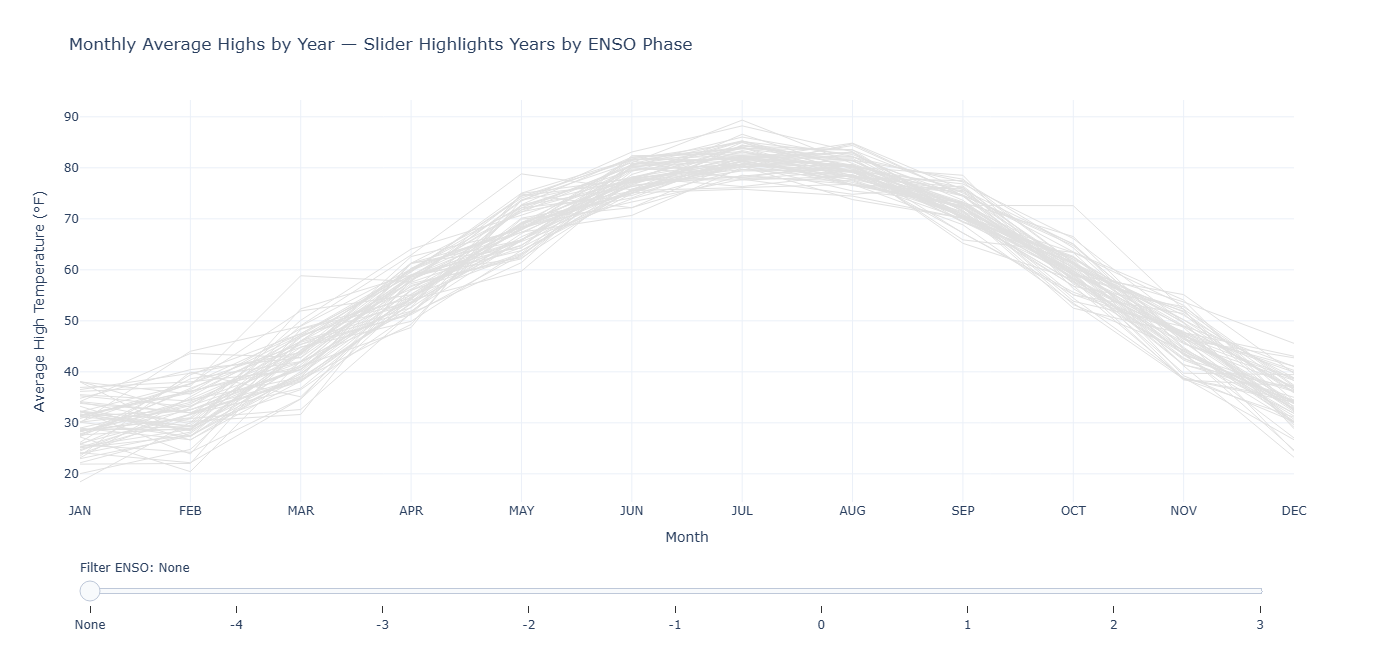

In [5]:

# =========================
# Load & basic preparation
# =========================
df_raw = pd.read_csv("data/full_data_encoded.csv", low_memory=False)

# Keep only what's needed for plotting temps
df = df_raw[["Year", "Month", "high"]].dropna()
df["high"] = pd.to_numeric(df["high"], errors="coerce")

# Month order for the x-axis
month_order = ["JAN","FEB","MAR","APR","MAY","JUN","JUL","AUG","SEP","OCT","NOV","DEC"]
df["Month"] = pd.Categorical(df["Month"], categories=month_order, ordered=True)

# If duplicates exist per Year×Month, average them (retain current pandas behavior)
df = df.groupby(["Year", "Month"], as_index=False, observed=False)["high"].mean()

# =========================
# Compute ENSO for each plotted "Season_Year" (DJF)
# =========================
# For ENSO we need DJF per-season values: Dec belongs to the following year.
enso_df = df_raw[["Year", "Month", "ENSO_encoded"]].dropna()
enso_df["ENSO_encoded"] = pd.to_numeric(enso_df["ENSO_encoded"], errors="coerce")
enso_df["Month"] = pd.Categorical(enso_df["Month"], categories=month_order, ordered=True)

# Keep DJF only
winter_months = ["DEC", "JAN", "FEB"]
enso_winter = enso_df[enso_df["Month"].isin(winter_months)].copy()

# Season_Year: DEC counts toward next year's winter
enso_winter["Season_Year"] = enso_winter.apply(
    lambda r: int(r["Year"]) + 1 if r["Month"] == "DEC" else int(r["Year"]), axis=1
)

def safe_mode(vals):
    vals = [v for v in vals if pd.notna(v)]
    if not vals:
        return np.nan
    try:
        return mode(vals)
    except Exception:
        # In case of ties, pick the value with smallest absolute magnitude (closest to neutral),
        # tie-breaking by the actual value.
        return sorted(vals, key=lambda x: (abs(x), x))[0]

# One ENSO code per Season_Year (mode over DJF)
enso_per_year = (enso_winter.groupby("Season_Year")["ENSO_encoded"]
                 .apply(lambda s: safe_mode(list(s.values)))
                 .to_dict())

# =========================
# Build time series per complete year for plotting
# =========================
years_all = sorted(df["Year"].unique())
series_by_year = {}
complete_years = []
for y in years_all:
    s = df[df["Year"] == y].set_index("Month").reindex(month_order)["high"]
    if s.notna().all():  # keep only years with all 12 months
        series_by_year[y] = s.values.tolist()
        complete_years.append(y)

years = complete_years

# Map each plotted year to its ENSO code using Season_Year == that calendar year
# (i.e., winter defined by Dec(prev year), Jan, Feb of current year)
enso_for_plotted_year = {y: enso_per_year.get(y, np.nan) for y in years}

# =========================
# Color map (fully opaque, saturated)
# =========================
# Dark red -> lighter red -> neutral dark gray -> blue ramp to dark blue
enso_order = [-4, -3, -2, -1, 0, 1, 2, 3]
enso_color_map = {
    -4: "#8B0000",  # dark red
    -3: "#C62828",
    -2: "#E53935",
    -1: "#FF1744",
     0: "#424242",  # strong neutral (dark gray so it stands out when highlighted)
     1: "#1E88E5",
     2: "#1565C0",
     3: "#0D47A1"   # dark blue
}

# =========================
# Build the figure
# =========================
fig = go.Figure()

# 1) Background gray lines (very light gray; thin; always visible)
for y in years:
    fig.add_trace(go.Scatter(
        x=month_order, y=series_by_year[y],
        mode="lines",
        line=dict(color="#E0E0E0", width=1),  # very light gray
        hoverinfo="skip",
        showlegend=False,
        name=f"{y} (bg)"
    ))

# 2) Highlight layer (one trace per year), fully opaque & hidden by default
for y in years:
    enso_code = enso_for_plotted_year[y]
    color = enso_color_map.get(int(enso_code), "#424242") if pd.notna(enso_code) else "#424242"
    fig.add_trace(go.Scatter(
        x=month_order, y=series_by_year[y],
        mode="lines+markers",
        line=dict(color=color, width=4),      # thicker to pop from background
        marker=dict(size=6, color=color, line=dict(width=0.5, color="black")),
        opacity=1.0,                          # fully opaque
        name=str(y),
        text=[f"Year {y} | ENSO {enso_code}"]*12,
        hovertemplate="%{text}<br>Month: %{x}<br>High: %{y:.1f}°F<extra></extra>",
        visible=False,
        showlegend=False
    ))

# Helper to set which highlight traces are visible for a selected ENSO phase
# First len(years) traces are background; next len(years) traces are highlights.
n = len(years)

def visibility_for_enso(selected_enso):
    # Gray always visible; highlights off by default
    vis = [True]*n + [False]*n
    if selected_enso is None:
        return vis
    for i, y in enumerate(years):
        val = enso_for_plotted_year[y]
        if pd.notna(val) and int(val) == selected_enso:
            vis[n + i] = True
    return vis

# Slider steps: "None" + each ENSO code
steps = []
# "None" step (no highlights)
steps.append({
    "method": "update",
    "label": "None",
    "args": [
        {"visible": visibility_for_enso(None)},
        {"title": "Monthly Average Highs — All Years (Gray)"}
    ]
})
# One step per ENSO phase
for e in enso_order:
    steps.append({
        "method": "update",
        "label": str(e),
        "args": [
            {"visible": visibility_for_enso(e)},
            {"title": f"Monthly Average Highs — Highlight: ENSO {e}"}
        ]
    })

# Layout
fig.update_layout(
    title="Monthly Average Highs by Year — Slider Highlights Years by ENSO Phase",
    xaxis=dict(title="Month", categoryorder="array", categoryarray=month_order),
    yaxis=dict(title="Average High Temperature (°F)"),
    template="plotly_white",
    width=1150,
    height=650,
    sliders=[{
        "active": 0,  # default to 'None'
        "y": -0.06,
        "pad": {"t": 30, "b": 10},
        "len": 0.98,
        "currentvalue": {"prefix": "Filter ENSO: ", "visible": True},
        "steps": steps
    }]
)

fig.show()

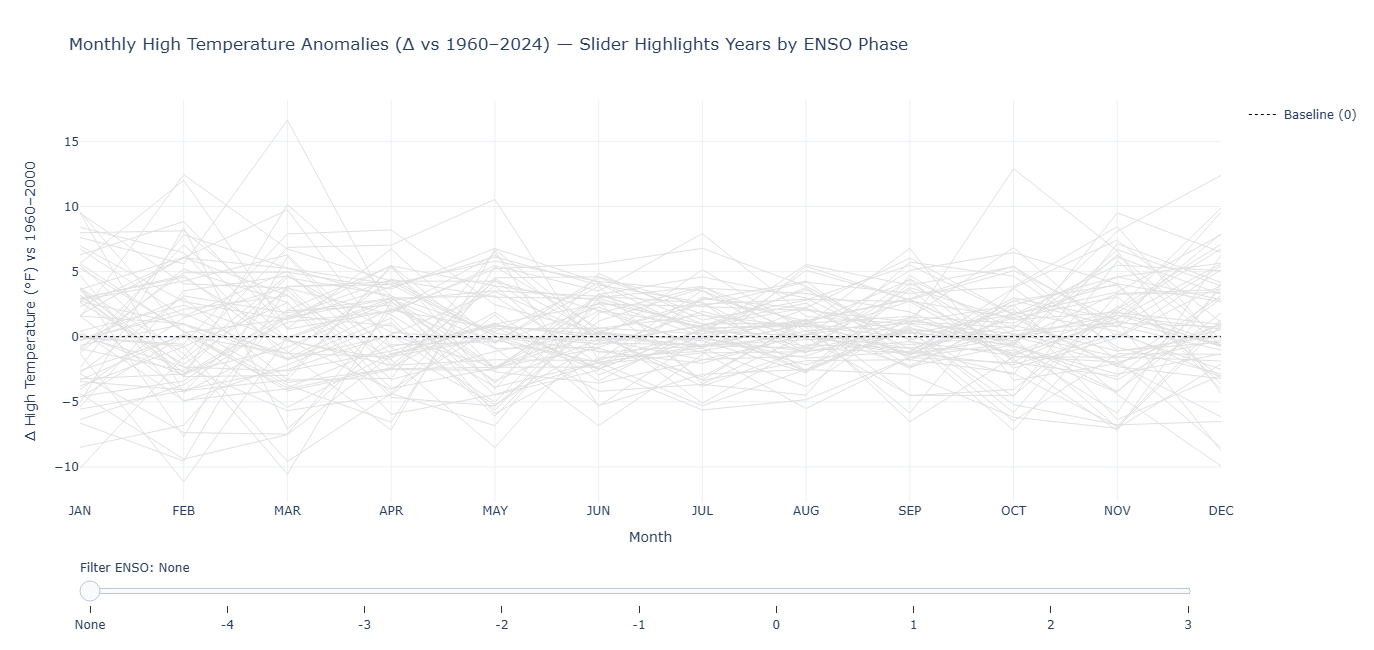

In [6]:
# =========================
# Load & basic preparation
# =========================
df_raw = pd.read_csv("data/full_data_encoded.csv", low_memory=False)

# Keep only what's needed for temps
df = df_raw[["Year", "Month", "high"]].dropna()
df["high"] = pd.to_numeric(df["high"], errors="coerce")

# Order months for x-axis
month_order = ["JAN","FEB","MAR","APR","MAY","JUN","JUL","AUG","SEP","OCT","NOV","DEC"]
df["Month"] = pd.Categorical(df["Month"], categories=month_order, ordered=True)

# If duplicates exist per Year×Month, average them
df = df.groupby(["Year", "Month"], as_index=False, observed=False)["high"].mean()

# =========================
# Build monthly 1960–2000 baseline and anomalies
# =========================
baseline_df = df[(df["Year"] >= 1960) & (df["Year"] <= 2000)]
# Monthly mean baseline (JAN mean, FEB mean, ... over 1960–2000)
baseline_by_month = (baseline_df.groupby("Month", observed=False)["high"]
                     .mean().reindex(month_order))

# For each Year, create a 12-month series and subtract the monthly baseline
years_all = sorted(df["Year"].unique())
series_by_year_abs = {}   # absolute temps
series_by_year_dev = {}   # anomalies (Δ vs baseline)
complete_years = []
for y in years_all:
    s = df[df["Year"] == y].set_index("Month").reindex(month_order)["high"]
    if s.notna().all():  # only keep complete years (12 months)
        series_by_year_abs[y] = s.values.tolist()
        series_by_year_dev[y] = (s - baseline_by_month).values.tolist()
        complete_years.append(y)

years = complete_years

# =========================
# Compute ENSO code per Season_Year (DJF)
# =========================
enso_df = df_raw[["Year", "Month", "ENSO_encoded"]].dropna()
enso_df["ENSO_encoded"] = pd.to_numeric(enso_df["ENSO_encoded"], errors="coerce")
enso_df["Month"] = pd.Categorical(enso_df["Month"], categories=month_order, ordered=True)

winter_months = ["DEC", "JAN", "FEB"]
enso_winter = enso_df[enso_df["Month"].isin(winter_months)].copy()

# Season_Year: DEC counts toward the next year's winter
enso_winter["Season_Year"] = enso_winter.apply(
    lambda r: int(r["Year"]) + 1 if r["Month"] == "DEC" else int(r["Year"]),
    axis=1
)

def safe_mode(vals):
    vals = [v for v in vals if pd.notna(v)]
    if not vals:
        return np.nan
    try:
        return mode(vals)
    except Exception:
        # tie-breaker: closest to neutral, then by value
        return sorted(vals, key=lambda x: (abs(x), x))[0]

# One ENSO code per Season_Year (mode over DJF)
enso_per_year = (enso_winter.groupby("Season_Year")["ENSO_encoded"]
                 .apply(lambda s: safe_mode(list(s.values)))
                 .to_dict())

# Map each plotted calendar year to its DJF Season_Year ENSO
enso_for_plotted_year = {y: enso_per_year.get(y, np.nan) for y in years}

# =========================
# Colors (fully opaque, saturated)
# =========================
enso_order = [-4, -3, -2, -1, 0, 1, 2, 3]
enso_color_map = {
    -4: "#8B0000",  # dark red
    -3: "#C62828",
    -2: "#E53935",
    -1: "#FF1744",
     0: "#424242",  # dark gray for neutral highlight
     1: "#1E88E5",
     2: "#1565C0",
     3: "#0D47A1"   # dark blue
}

# =========================
# Build the figure (anomalies)
# =========================
fig = go.Figure()

# 1) Background gray lines: anomalies for all years (very light gray)
for y in years:
    fig.add_trace(go.Scatter(
        x=month_order, y=series_by_year_dev[y],
        mode="lines",
        line=dict(color="#E0E0E0", width=1),
        hoverinfo="skip",
        showlegend=False,
        name=f"{y} (bg)"
    ))

# 2) Highlight layer (one per year), fully opaque & hidden by default
for y in years:
    enso_code = enso_for_plotted_year[y]
    color = enso_color_map.get(int(enso_code), "#424242") if pd.notna(enso_code) else "#424242"
    fig.add_trace(go.Scatter(
        x=month_order, y=series_by_year_dev[y],
        mode="lines+markers",
        line=dict(color=color, width=4),
        marker=dict(size=6, color=color, line=dict(width=0.5, color="black")),
        opacity=1.0,
        name=str(y),
        text=[f"Year {y} | ENSO {enso_code}"]*12,
        hovertemplate="%{text}<br>Month: %{x}<br>ΔHigh: %{y:.1f}°F<extra></extra>",
        visible=False,
        showlegend=False
    ))

# Reference zero line (baseline)
fig.add_trace(go.Scatter(
    x=month_order, y=[0]*12,
    mode="lines",
    line=dict(color="black", width=1, dash="dot"),
    name="Baseline (0)",
    hoverinfo="skip",
    showlegend=True
))

# Helper to set visibility based on ENSO phase
# First len(years) traces: background; next len(years): highlights; last trace: zero line
n = len(years)

def visibility_for_enso(selected_enso):
    vis = [True]*n + [False]*n + [True]  # gray + (highlights off) + zero line on
    if selected_enso is None:
        return vis
    for i, y in enumerate(years):
        val = enso_for_plotted_year[y]
        if pd.notna(val) and int(val) == selected_enso:
            vis[n + i] = True
    return vis

# Slider steps
steps = []
steps.append({  # None = no highlights
    "method": "update",
    "label": "None",
    "args": [
        {"visible": visibility_for_enso(None)},
        {"title": "Monthly High Temperature Anomalies (Δ vs 1960–2024) — All Years (Gray)"}
    ]
})
for e in enso_order:
    steps.append({
        "method": "update",
        "label": str(e),
        "args": [
            {"visible": visibility_for_enso(e)},
            {"title": f"Monthly High Temperature Anomalies (Δ vs 1960–2000) — Highlight: ENSO {e}"}
        ]
    })

# Layout
fig.update_layout(
    title="Monthly High Temperature Anomalies (Δ vs 1960–2024) — Slider Highlights Years by ENSO Phase",
    xaxis=dict(title="Month", categoryorder="array", categoryarray=month_order),
    yaxis=dict(title="Δ High Temperature (°F) vs 1960–2000"),
    template="plotly_white",
    width=1150,
    height=650,
    sliders=[{
        "active": 0,
        "y": -0.06,
        "pad": {"t": 30, "b": 10},
        "len": 0.98,
        "currentvalue": {"prefix": "Filter ENSO: ", "visible": True},
        "steps": steps
    }]
)

fig.show()